In [1]:
# Importing required libraries/dependencies
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
get_ipython().run_line_magic('matplotlib', 'inline')
import itertools
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd, datetime
from pandas import DataFrame
import seaborn as sns
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time
from unicodedata import normalize
import xgboost as xgb

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Importing training data provided by Kaggle 

In [2]:
#  Import and read the charity_data.csv.
# import pandas as pd 
# application_df = pd.read_csv("Resources/charity_data.csv")
# application_df.head()
train_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/grocery_train.csv')
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


# Uncategorizing sales data by 'family' to get a per day sum

In [3]:
# check for null values in the dateset 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [4]:
# drop store and id columns 
cleaned_train = train_df.drop(['id', 'store_nbr', 'family'], axis =1)
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   sales        float64
 2   onpromotion  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 68.7+ MB


In [5]:
daily_sales = cleaned_train.groupby('date').sum().reset_index()
daily_sales

,date,sales,onpromotion
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,0
2,2013-01-03,361461.231124,0
3,2013-01-04,354459.677093,0
4,2013-01-05,477350.121229,0
...,...,...,...
1679,2017-08-11,826373.722022,14179
1680,2017-08-12,792630.535079,8312
1681,2017-08-13,865639.677471,9283
1682,2017-08-14,760922.406081,8043


In [6]:
#print average of all relevant integer type columns 
averages_df = cleaned_train[["sales","onpromotion"]].mean()
averages_df 

sales          357.775749
onpromotion      2.602770
dtype: float64

# Preparing data for first visualization

In [7]:
# drop store and id columns 
sales_train = train_df.drop(['id', 'store_nbr', 'family', 'onpromotion'], axis =1)
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   sales   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ MB


In [8]:
# convert 'date' column to datetime format for merging with other CSV's 
sales_train['date'] = pd.to_datetime(cleaned_train['date'])
sales_train.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [9]:
# converting date to a Month period, and then summing the number of items in each month 
sales_train['date'] = sales_train['date'].dt.to_period("M")
# cleaned_train['date'] = cleaned_train['date'].dt.month
monthly_sales = sales_train.groupby('date').sum().reset_index()
monthly_sales.head()

,date,sales
0,2013-01,1.032762e+07
1,2013-02,9.658960e+06
2,2013-03,1.142850e+07
3,2013-04,1.099346e+07
4,2013-05,1.159770e+07


In [10]:
# convert the resulting date column to timestamp datatype 
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head()

,date,sales
0,2013-01-01,1.032762e+07
1,2013-02-01,9.658960e+06
2,2013-03-01,1.142850e+07
3,2013-04-01,1.099346e+07
4,2013-05-01,1.159770e+07


In [11]:
# changing label colors to white to account for dark mode settings 
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

Text(0.5, 1.0, 'Monthly Customer Sales')

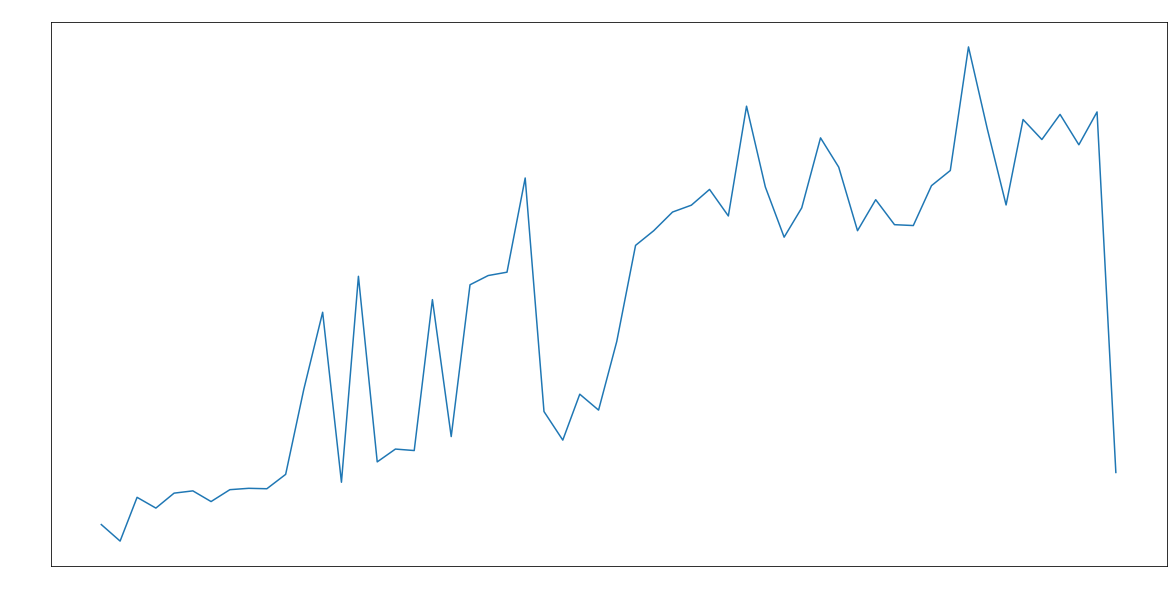

In [11]:
# Visualization
plt.figure(figsize=(20,10))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
# plt.show

In [12]:
# call the difference on the sales columns to make the sales data stationary, remember 2013-02-01 reflects sales for the entire previous month (JANUARY)
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,9.658960e+06,-6.686650e+05
2,2013-03-01,1.142850e+07,1.769537e+06
3,2013-04-01,1.099346e+07,-4.350323e+05
4,2013-05-01,1.159770e+07,6.042393e+05
5,2013-06-01,1.168934e+07,9.164006e+04


<function matplotlib.pyplot.show(close=None, block=None)>

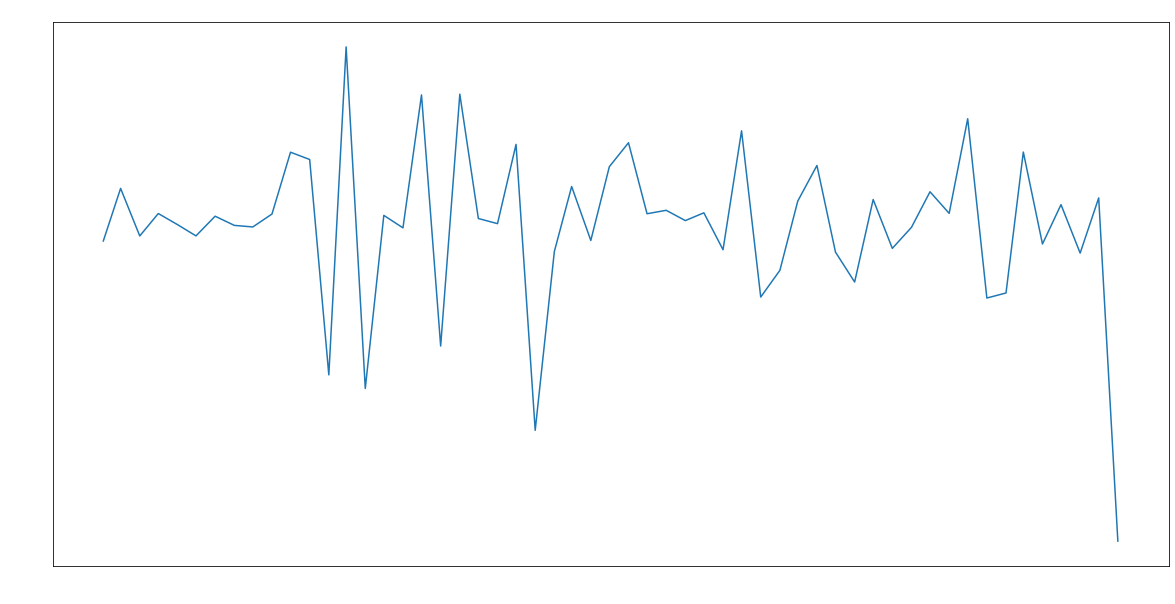

In [13]:
# visualizing 
plt.figure(figsize=(20,10))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show

In [13]:
#dropping off sales and date 
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)
supervised_data.head()

,sales_diff
1,-6.686650e+05
2,1.769537e+06
3,-4.350323e+05
4,6.042393e+05
5,9.164006e+04


In [14]:
#preparing the supervised data, we got the sales difference for all stores 
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-1.731287e+04,5.514431e+04,4.803883e+05,-431943.454563,91640.055217,604239.269015,-435032.299476,1.769537e+06,-6.686650e+05
1,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-1.731287e+04,5.514431e+04,480388.311792,-431943.454563,91640.055217,604239.269015,-4.350323e+05,1.769537e+06
2,-7.504333e+06,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-1.731287e+04,55144.312395,480388.311792,-431943.454563,91640.055217,6.042393e+05,-4.350323e+05
3,5.185342e+05,-7.504333e+06,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-17312.871349,55144.312395,480388.311792,-431943.454563,9.164006e+04,6.042393e+05
4,-5.982709e+04,5.185342e+05,-7.504333e+06,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,580938.932467,-17312.871349,55144.312395,480388.311792,-4.319435e+05,9.164006e+04


In [15]:
# split the data into Train and Test 
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (31, 13)
Test Data Shape:  (12, 13)


In [16]:
# scaling feature values to restrict them to indicated feature range
scaler = MinMaxScaler(feature_range=(-1,1))
# fit the train data within the scaler 
scaler.fit(train_data)
# transforming train and test data 
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [17]:
#  in a supervised dataframe the first column always corresponds to the output, remaining column act as the input features, this can be seen in the output of this cell 
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (31, 12)
y_train Shape:  (31,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


In [18]:
# create prediction dataframe ti merge the predicted sales of all trained algorithms 
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [19]:
 # creating dataframe to hold the actual sales of the last 13 months 
 actual_sales = monthly_sales['sales'][-13:].to_list()
 actual_sales

[22452414.3178949,
 22417448.0969967,
 24030389.816292,
 24642640.1973935,
 29640287.5793851,
 26328159.9357051,
 23250112.3749368,
 26704017.6908793,
 25895308.4895551,
 26911847.250593,
 25682822.1249936,
 27011477.5658307,
 12433322.9407775]

# Beginning of linear regression Section

In [20]:
# create linear regression model and predicted output 
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

In [17]:
# we need to transform the predicted values back to their original scale 
lr_predict = lr_predict.reshape(-1,1)
# notice that the brackets are needed in the line below because we are passing in a list/array 
lr_predict_test = np.concatenate([lr_pre, X_test], axis = 1)
lr_predict_test = scaler.inverse_transform(lr_predict_test)

NameError: ignored

# Merging training data with other holiday CSV




In [21]:
# counting number of rows in training set prior to cleaning 
len(train_df)


3000888

In [22]:
# convert 'date' column to datetime format for merging with other CSV's 
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [23]:
# read in the holiday data file 
# holiday_file = "resources/holidays_events.csv"
# holiday_df = pd.read_csv(holiday_file)
# holiday_df.tail()

holiday_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/holiday.csv')
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [24]:
# counting number of rows in holiday df 
len(holiday_df)

350

In [25]:
# converting date column from string to datetime format 
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [26]:
#drop rows that notate whether the holiday was moved by the government 
cleaned_hol = holiday_df[holiday_df['transferred'] == False]

In [27]:
# checking how many holidays were affected by this (twelve total )
len(cleaned_hol)

338

In [28]:
cleaned_hol.drop_duplicates(subset='date', inplace=True)
len(cleaned_hol)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


300

In [29]:
# drop transferred, cluster and type_x column 
holiday_df = cleaned_hol.drop(['type', "locale_name", "transferred" ], axis=1)
holiday_df

,date,locale,description
0,2012-03-02,Local,Fundacion de Manta
1,2012-04-01,Regional,Provincializacion de Cotopaxi
2,2012-04-12,Local,Fundacion de Cuenca
3,2012-04-14,Local,Cantonizacion de Libertad
4,2012-04-21,Local,Cantonizacion de Riobamba
...,...,...,...
344,2017-12-22,Local,Cantonizacion de Salinas
346,2017-12-23,National,Navidad-2
347,2017-12-24,National,Navidad-1
348,2017-12-25,National,Navidad


In [30]:
merged_holiday = pd.merge(train_df, holiday_df, on ='date', how="left")
merged_holiday

,id,date,store_nbr,family,sales,onpromotion,locale,description
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba


In [31]:
len(merged_holiday)

3000888

# Further merging the hoilday and training dataframe with the oil price CSV

In [32]:
# # Read in the oil prices data file 
# oil_file = "resources/oil.csv"
# oil_df = pd.read_csv(oil_file)
# oil_df.head()

oil_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/oil.csv')
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [33]:
# drop null values from oil dataframe/csv
cleaned_oil=oil_df.dropna()
cleaned_oil

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [36]:
#print average of oil price column for binning purposes 
oil_average = cleaned_oil[["dcoilwtico"]].mean()
oil_average

dcoilwtico    67.714366
dtype: float64

In [39]:
# changing date data type in preparation for merging 
cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])
cleaned_oil.dtypes

<ipython-input-39-8903d12f85c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])


date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [40]:
final_train = pd.merge(merged_holiday, cleaned_oil, on ='date', how="left")
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN
...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57


In [41]:
len(final_train)

3000888

# Preparing second visualization 

In [42]:
# adding day of week name for employee scheduling analysis etc. 
final_train['weekday']= final_train['date'].dt.day_name()
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,Tuesday
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,Tuesday
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,Tuesday
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,Tuesday
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,Tuesday


In [43]:
# removing last three letters of weekday column to make plot x-labels of next cell legible 
final_train['weekday'] = final_train['weekday'].str.replace(r'day$', '')
final_train

<ipython-input-43-408e0a0a7cb2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  final_train['weekday'] = final_train['weekday'].str.replace(r'day$', '')


,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,Tues
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,Tues
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,Tues
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,Tues
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,Tues
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tues
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tues
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tues
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,Tues


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 648x432 with 0 Axes>

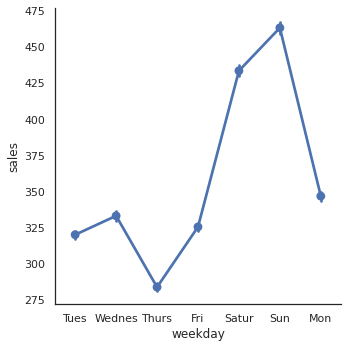

In [44]:
# Sales trend over days, **************!!!!!!!!!!!DO NOT RE-RUN THIS CELL, stick with saved output -- TAKES TOO LONG!!!!!!! *****************
sns.set( style = "white" ) 
# # style = white in previous line of code needed to counter balance dark mode setting
# Set figure size (width, height) in inches
plt.figure(figsize = ( 9 , 6 ))
sns.factorplot(data = final_train, x = "weekday", y = "sales")

# Adding features/columns to help with hyperparameter tuning. 


In [45]:
# Since the dataframe starts and ends on a Tuesday (1 = Tuesday 2 = Wednesday etc.)
final_train['weekdaynumber'] = final_train['date'].dt.dayofweek
# adding in week of year for further analysis/visualizations, Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead
final_train['week_of_year'] = final_train['date'].dt.weekofyear
# adding year possible visualizations 
final_train['year'] = final_train['date'].dt.year
# adding month columnn for possible seasonal hire analysis
final_train['month'] = final_train['date'].dt.month
# adding quarter column for further analysis 
final_train['quarter'] = pd.PeriodIndex(final_train.date, freq='Q')
final_train

<ipython-input-45-97b772409a78>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  final_train['week_of_year'] = final_train['date'].dt.weekofyear


,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday,weekdaynumber,week_of_year,year,month,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3


# Categorizing each date as either national holiday (2) local/regional(1) or non-holiday (0)

In [46]:
# counting number of non-holidays in df 
nan_count = final_train['locale'].isna().sum()
nan_count

2567862

In [47]:
# replacing NaN holiday description cells with 0 
final_train['locale'] = final_train['locale'].fillna(0)

In [48]:
# setting dates that fall on a holiday = to 2 if national, 1 if local/regional  
final_train['holiday'] = final_train['locale'].replace({'National': 2, 'Local': 1, 'Regional': 1})
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday,weekdaynumber,week_of_year,year,month,quarter,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1


In [49]:
# check volume of holiday or not 
print(final_train['holiday'].value_counts())

0    2567862
2     229878
1     203148
Name: holiday, dtype: int64


In [50]:
# check data types for SQL compatibility 
final_train.dtypes

id                        int64
date             datetime64[ns]
store_nbr                 int64
family                   object
sales                   float64
onpromotion               int64
locale                   object
description              object
dcoilwtico              float64
weekday                  object
weekdaynumber             int64
week_of_year              int64
year                      int64
month                     int64
quarter           period[Q-DEC]
holiday                   int64
dtype: object

In [51]:
# drop store and id columns 
cleaned_train = final_train.drop(['id', 'store_nbr', 'weekdaynumber'], axis =1)
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   family        object        
 2   sales         float64       
 3   onpromotion   int64         
 4   locale        object        
 5   description   object        
 6   dcoilwtico    float64       
 7   weekday       object        
 8   week_of_year  int64         
 9   year          int64         
 10  month         int64         
 11  quarter       period[Q-DEC] 
 12  holiday       int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(4), period[Q-DEC](1)
memory usage: 320.5+ MB




```
# Creating separate dataframe/model of oil testing set 

> this df will have fewer rows due to missing data

In [52]:
oil_train=final_train.dropna(subset=['dcoilwtico'])
oil_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday,weekdaynumber,week_of_year,year,month,quarter,holiday
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0
1783,1783,2013-01-02,1,BABY CARE,0.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0
1784,1784,2013-01-02,1,BEAUTY,2.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0
1786,1786,2013-01-02,1,BOOKS,0.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1


In [53]:
#print average of oil price column for binning purposes 
averages_df = oil_train[["dcoilwtico"]].mean()
averages_df 

dcoilwtico    67.925589
dtype: float64

In [54]:
# display zero in oil_price column if oil price is below $75 per barrel and a one on days when oil price is above $75 per barrel 
oil_train["oil_price"] = np.where(oil_train["dcoilwtico"] > 75, 0, 1)
oil_train

<ipython-input-54-9663669ff8f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_train["oil_price"] = np.where(oil_train["dcoilwtico"] > 75, 0, 1)


,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday,weekdaynumber,week_of_year,year,month,quarter,holiday,oil_price
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0,0
1783,1783,2013-01-02,1,BABY CARE,0.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0,0
1784,1784,2013-01-02,1,BEAUTY,2.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0,0
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0,0
1786,1786,2013-01-02,1,BOOKS,0.000,0,0,NaN,93.14,Wednes,2,1,2013,1,2013Q1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1,1


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


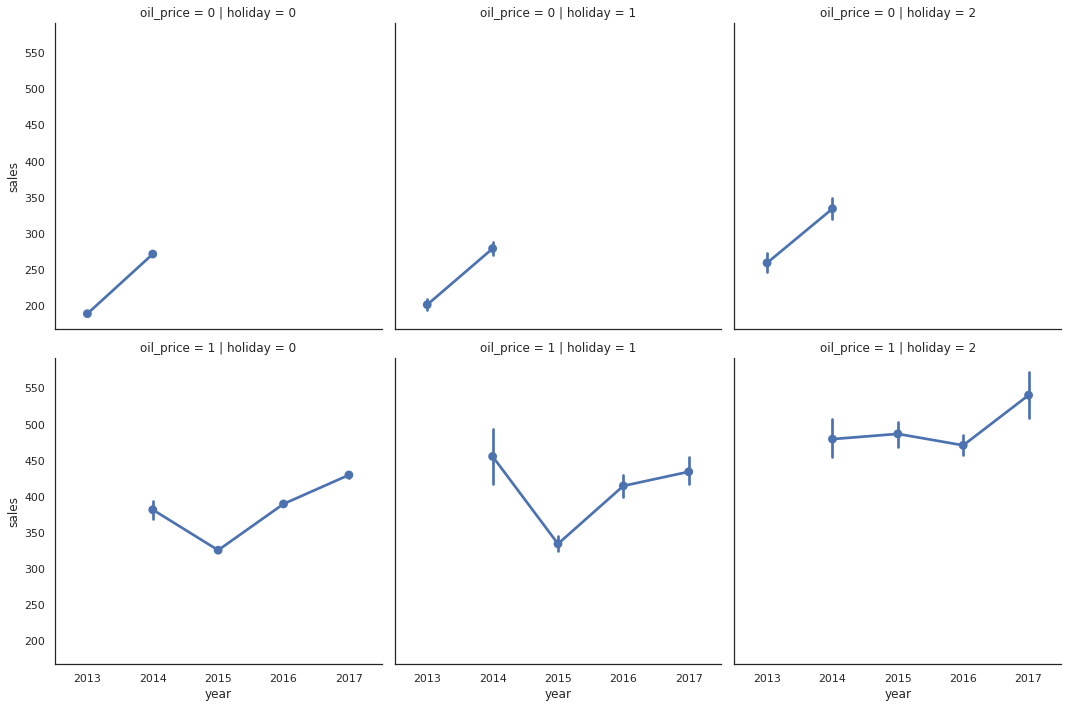

In [55]:
# Sales trend over the months and year, remember to change factorplot to catplot ********!!!!!!!!!!!!!!DO NOT RE-RUN THIS CELL (stick with saved output) TAKES FOREVER!!!!!!!!!!****************
sns.factorplot(data = oil_train, x ="year", y = "sales", 
               col = 'holiday', # per store type in cols
               row = "oil_price")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


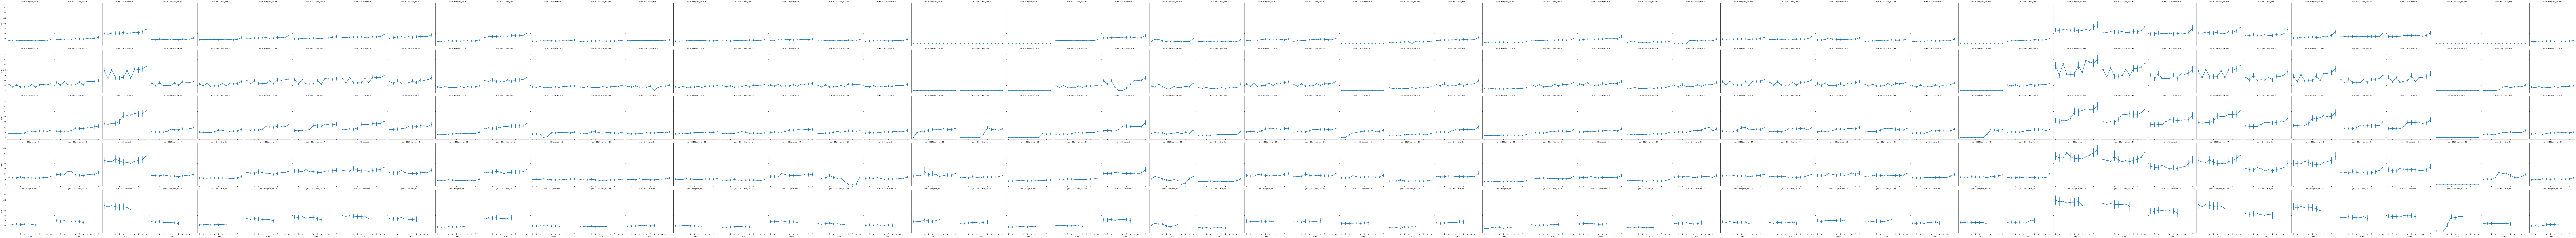

In [53]:
# # Sales trend over the months and year, remember to change factorplot to catplot 
# sns.factorplot(data = final_train, x ="month", y = "sales", 
#                col = 'store_nbr', # per store type in cols
#                row = "year")

# "onpromotion" model DF creation (in case binary output is needed for this column)

In [57]:
#print average of all relevant integer type columns 
average_promotions = cleaned_train[["onpromotion"]].mean()
average_promotions

onpromotion    2.60277
dtype: float64

In [65]:
onpromotion_df=final_train.groupby("date")[["onpromotion"]].sum()
onpromotion_df

,onpromotion
date,
2013-01-01,0
2013-01-02,0
2013-01-03,0
2013-01-04,0
2013-01-05,0
...,...
2017-08-11,14179
2017-08-12,8312
2017-08-13,9283


In [59]:
indexed_train = final_train.set_index('date')
indexed_train

,id,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekday,weekdaynumber,week_of_year,year,month,quarter,holiday
date,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
2013-01-01,1,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
2013-01-01,2,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
2013-01-01,3,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
2013-01-01,4,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,Tues,1,1,2013,1,2013Q1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1
2017-08-15,3000885,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,Tues,1,33,2017,8,2017Q3,1


Text(0.5, 1.0, 'Daily Sales Over Time')

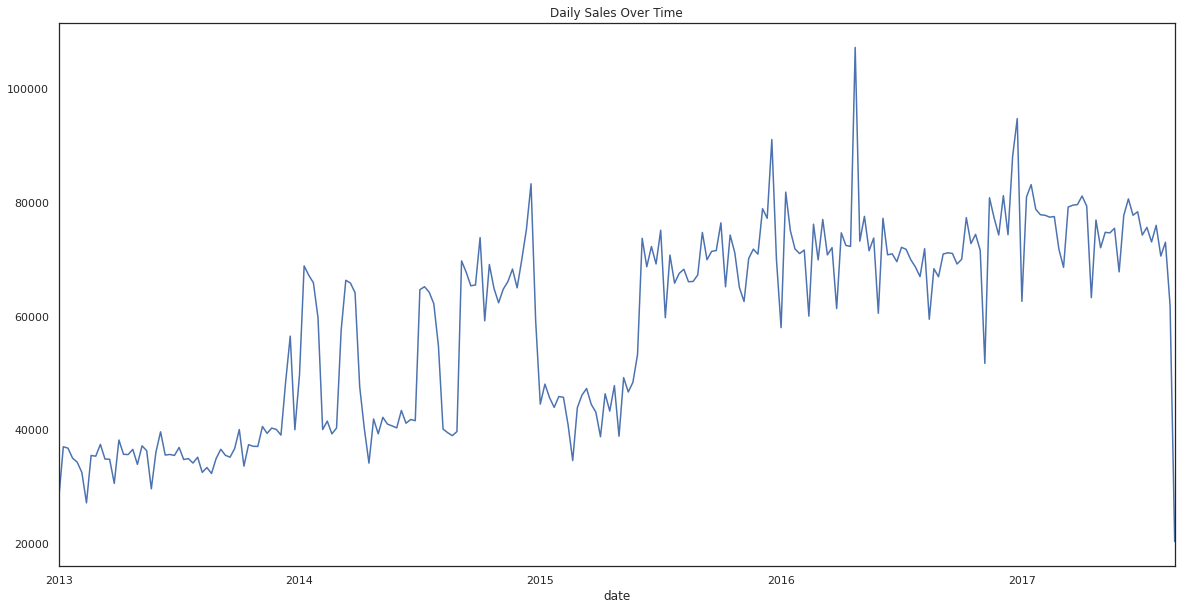

In [61]:
# Data Preparation: input should be float type
indexed_train['sales'] = indexed_train['sales'] * 1.0
# Assigning one store from each category
sales_a = indexed_train[indexed_train.store_nbr == 1]['sales']
# Trend
sales_a.resample('W').sum().plot(figsize=(20, 10))
plt.title("Daily Sales Over Time")

# Reading in and cleaning test data from Kaggle 

In [62]:
test_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/grocery_test.csv')
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [63]:
# check for null values in the dateset 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [64]:
# drop store and id columns 
cleaned_test = test_df.drop(['id', 'store_nbr', 'family', 'onpromotion'], axis =1)
cleaned_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    28512 non-null  object
dtypes: object(1)
memory usage: 222.9+ KB


# Reading in and cleaning transactions CSV from Kaggle for Earthquake analysis

In [69]:
# transactions_file = "resources/transactions.csv"
# trans_df = pd.read_csv(transactions_file)
# trans_df.head()

trans_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/transactions.csv')
trans_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [70]:
len(trans_df)

83488

In [71]:
# check data types for SQL compatibility 
trans_df.dtypes

date            object
store_nbr        int64
transactions     int64
dtype: object

In [72]:
# convert 'date' column to datetime format for merging with other CSV's 
trans_df['date'] = pd.to_datetime(trans_df['date'])
trans_df.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [75]:
# we are focusing our machine learning models on thirty days from each year included 
april_df = trans_df[((trans_df['date'] >= '2013-04-16') & (trans_df['date'] < '2013-05-16'))
    | ((trans_df['date'] >= '2014-04-16') & (trans_df['date'] < '2014-05-16'))
    | ((trans_df['date'] >= '2015-04-16') & (trans_df['date'] < '2015-05-16'))
    | ((trans_df['date'] >= '2016-04-16') & (trans_df['date'] < '2016-05-16'))
    | ((trans_df['date'] >= '2017-04-16') & (trans_df['date'] < '2017-05-16'))]
april_df

,date,store_nbr,transactions
4785,2013-04-16,1,1757
4786,2013-04-16,2,1742
4787,2013-04-16,3,2813
4788,2013-04-16,4,1400
4789,2013-04-16,5,1565
...,...,...,...
78515,2017-05-15,50,2416
78516,2017-05-15,51,1525
78517,2017-05-15,52,1896
78518,2017-05-15,53,1013


In [76]:
# printing the number of rows in our datframe for quality assurance during merges 
len(april_df)

7443

# Reading in and cleaning stores CSV from Kaggle for Earthquake analysis

In [77]:
# #Read in the stores data file which has location info within Ecuador 
# stores_file = "resources/stores.csv"
# stores_df = pd.read_csv(stores_file)
# stores_df.head()

stores_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/stores.csv')
stores_df

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [79]:
# checking that store number type is int64 prior to merge 
len(stores_df)

54

In [80]:
# performing first merge 
store_april = pd.merge(stores_df, april_df, on ='store_nbr')
store_april.head()

,store_nbr,city,state,type,cluster,date,transactions
0,1,Quito,Pichincha,D,13,2013-04-16,1757
1,1,Quito,Pichincha,D,13,2013-04-17,1807
2,1,Quito,Pichincha,D,13,2013-04-18,1607
3,1,Quito,Pichincha,D,13,2013-04-19,1737
4,1,Quito,Pichincha,D,13,2013-04-20,1335


In [81]:
#checking that number of rows is staying consistent 
len(store_april)

7443

In [83]:
# performing left join to prevent rows being added during merge 
merged_holiday = pd.merge(store_april, cleaned_hol, on ='date', how="left")
merged_holiday.head()

,store_nbr,city,state,type_x,cluster,date,transactions,type_y,locale,locale_name,description,transferred
0,1,Quito,Pichincha,D,13,2013-04-16,1757,NaN,NaN,NaN,NaN,NaN
1,1,Quito,Pichincha,D,13,2013-04-17,1807,NaN,NaN,NaN,NaN,NaN
2,1,Quito,Pichincha,D,13,2013-04-18,1607,NaN,NaN,NaN,NaN,NaN
3,1,Quito,Pichincha,D,13,2013-04-19,1737,NaN,NaN,NaN,NaN,NaN
4,1,Quito,Pichincha,D,13,2013-04-20,1335,NaN,NaN,NaN,NaN,NaN


In [84]:
# confirming that number of rows is staying consistent 
len(merged_holiday)

7443

In [85]:
# cleaned_hol.squeeze()
indexed_oil = cleaned_oil.set_index('date', inplace=True)

In [86]:
cleaned_df = pd.concat([merged_holiday, indexed_oil], axis=1)
len(cleaned_df)

7443

In [88]:
# cleaned_df = pd.merge(trans_store_hol, cleaned_oil, on ='date')
cleaned_df

,store_nbr,city,state,type_x,cluster,date,transactions,type_y,locale,locale_name,description,transferred
0,1,Quito,Pichincha,D,13,2013-04-16,1757,NaN,NaN,NaN,NaN,NaN
1,1,Quito,Pichincha,D,13,2013-04-17,1807,NaN,NaN,NaN,NaN,NaN
2,1,Quito,Pichincha,D,13,2013-04-18,1607,NaN,NaN,NaN,NaN,NaN
3,1,Quito,Pichincha,D,13,2013-04-19,1737,NaN,NaN,NaN,NaN,NaN
4,1,Quito,Pichincha,D,13,2013-04-20,1335,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7438,54,El Carmen,Manabi,C,3,2017-05-11,747,NaN,NaN,NaN,NaN,NaN
7439,54,El Carmen,Manabi,C,3,2017-05-12,735,Holiday,Local,Puyo,Cantonizacion del Puyo,False
7440,54,El Carmen,Manabi,C,3,2017-05-13,1112,Additional,National,Ecuador,Dia de la Madre-1,False
7441,54,El Carmen,Manabi,C,3,2017-05-14,1212,Event,National,Ecuador,Dia de la Madre,False


In [89]:
# drop transferred, cluster and type_x column 
final_df = cleaned_df.drop(['type_x', "cluster", "transferred" ], axis=1)
final_df.head()

,store_nbr,city,state,date,transactions,type_y,locale,locale_name,description
0,1,Quito,Pichincha,2013-04-16,1757,NaN,NaN,NaN,NaN
1,1,Quito,Pichincha,2013-04-17,1807,NaN,NaN,NaN,NaN
2,1,Quito,Pichincha,2013-04-18,1607,NaN,NaN,NaN,NaN
3,1,Quito,Pichincha,2013-04-19,1737,NaN,NaN,NaN,NaN
4,1,Quito,Pichincha,2013-04-20,1335,NaN,NaN,NaN,NaN


In [90]:
final_df.dtypes

store_nbr                int64
city                    object
state                   object
date            datetime64[ns]
transactions             int64
type_y                  object
locale                  object
locale_name             object
description             object
dtype: object

In [91]:
len(final_df)

7443

In [ ]:
#Create SQL Alchemy engine to postgres database "IMDB_db"
protocol = 'postgresql'
username = 'postgres'
password = '0206Teddy'
host = 'localhost'
port = 5432
database_name = 'grocery'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [ ]:
#show the existing table names in the database
engine.table_names()

In [ ]:
#write the data in the dataframe to the database table
final_df.to_sql(name='earthquake_data', con=engine, if_exists='replace', index=False)

In [ ]:
#Query the carbon emissions data table to confirm the above data load
pd.read_sql_query('select * from public."earthquake_data"', con=engine)

In [ ]:
pd.read_sql_query('select * from public."earthquake_data"', con=engine).count()